In [1]:
import os
import pickle
import numpy as np
from tqdm import tqdm
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import load_model
from PIL import Image
import matplotlib.pyplot as plt
import re

In [2]:
# Load the EfficientNetB7 model
efficientnet_model = EfficientNetB7(weights='imagenet')
efficientnet_model = Model(inputs=efficientnet_model.inputs, outputs=efficientnet_model.layers[-2].output)

In [3]:
# Directory paths
BASE_DIR = r"D:\minor2"
WORKING_DIR = r"D:\minor2"
augmented_img_dir = os.path.join(WORKING_DIR, 'augmented_images')
os.makedirs(augmented_img_dir, exist_ok=True)

In [4]:
# Data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [5]:
# Load captions file
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [6]:
# Create mapping of image to captions
mapping = {}
for line in captions_doc.split('\n'):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

In [7]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [8]:
# Clean captions function
def clean_captions(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # Convert caption to lowercase
            caption = captions[i].lower()

            # Remove non-alphabetical characters using regex
            caption = re.sub(r'[^a-z ]+', '', caption)

            # Replace multiple spaces with a single space
            caption = re.sub(r'\s+', ' ', caption).strip()

            # Add 'startseq' and 'endseq' tokens
            caption = 'startseq ' + caption + ' endseq'

            # Update the cleaned caption in the mapping
            captions[i] = caption

# Apply the cleaning function to the captions
clean_captions(mapping)

In [9]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq',
 'startseq a girl going into a wooden building endseq',
 'startseq a little girl climbing into a wooden playhouse endseq',
 'startseq a little girl climbing the stairs to her playhouse endseq',
 'startseq a little girl in a pink dress going into a wooden cabin endseq']

In [10]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [11]:
len(all_captions)

40455

In [12]:
all_captions[:10]

['startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq',
 'startseq a girl going into a wooden building endseq',
 'startseq a little girl climbing into a wooden playhouse endseq',
 'startseq a little girl climbing the stairs to her playhouse endseq',
 'startseq a little girl in a pink dress going into a wooden cabin endseq',
 'startseq a black dog and a spotted dog are fighting endseq',
 'startseq a black dog and a tricolored dog playing with each other on the road endseq',
 'startseq a black dog and a white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [13]:
print(efficientnet_model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 600, 600, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 600, 600, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 600, 600, 3)       │               7 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 600, 600, 3)       │               0 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 601, 601, 3)       │               0 │ rescaling_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 300, 300, 64)      │           1,728 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 300, 300, 64)      │             256 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 300, 300, 64)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 300, 300, 64)      │             576 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 300, 300, 64)      │             256 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 300, 300, 64)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 64)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 64)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 16)          │           1,040 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 64)          │           1,088 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 64,097,687 (244.51 MB)

 Trainable params: 63,786,960 (243.33 MB)

 Non-trainable params: 310,727 (1.19 MB)

None


In [14]:
# Data augmentation and feature extraction
features = {}
augmented_mapping = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    img_path = os.path.join(directory, img_name)
    
    try:
        # Load and preprocess the image with target_size (600, 600) for EfficientNetB7
        image = load_img(img_path, target_size=(600, 600))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)  # Reshape for EfficientNetB7 input
        image = preprocess_input(image)

        # Generate augmented images and save them
        i = 0
        original_image_id = img_name.split('.')[0]
        for batch in datagen.flow(image, batch_size=1, save_to_dir=augmented_img_dir, 
                                  save_prefix=original_image_id, save_format='jpg'):
            # Extract features using EfficientNetB7 for the augmented image
            feature = efficientnet_model.predict(batch, verbose=0)
            
            # Store feature with a unique identifier for the augmented image
            image_id = original_image_id + f'_aug{i}'
            features[image_id] = feature

            # Assign the original captions to the augmented image
            augmented_mapping[image_id] = mapping[original_image_id]

            i += 1
            if i == 5:
                break

        # Also store the original image's feature
        feature = efficientnet_model.predict(image, verbose=0)
        features[original_image_id] = feature

    except Exception as e:
        print(f"Error processing {img_name}: {e}")


100%|███████████████████████████████████████████████████████████████████████████| 8091/8091 [11:31:38<00:00,  5.13s/it]


In [15]:
# Save the extracted features to a pickle file
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb') as f:
    pickle.dump(features, f)

In [16]:
# Merge original and augmented mappings
mapping.update(augmented_mapping)

In [17]:
# Save the updated mapping
with open(os.path.join(WORKING_DIR, 'mapping.pkl'), 'wb') as f:
    pickle.dump(mapping, f)

In [18]:
# Recreate the tokenizer
all_captions = [caption for key in mapping for caption in mapping[key]]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [19]:
# Save the tokenizer
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Tokenizer has been recreated and saved as 'tokenizer.pkl'")

Tokenizer has been recreated and saved as 'tokenizer.pkl'


In [20]:
# Max length of captions
max_length = max(len(caption.split()) for caption in all_captions)

In [21]:
# Split data into train and test sets
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.70)
train = image_ids[:split]
test = image_ids[split:]


In [22]:
# Data generator for training the model
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

In [23]:
# Define the captioning model
inputs1 = Input(shape=(2560,), name="image")  # EfficientNetB7 output feature size is 2560
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [25]:
# Train the model
epochs = 10
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    history=model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)


530/530 ━━━━━━━━━━━━━━━━━━━━ 2058s 4s/step - loss: 4.8509
530/530 ━━━━━━━━━━━━━━━━━━━━ 2612s 5s/step - loss: 3.1388
530/530 ━━━━━━━━━━━━━━━━━━━━ 2976s 6s/step - loss: 2.7339
530/530 ━━━━━━━━━━━━━━━━━━━━ 3280s 6s/step - loss: 2.4752
530/530 ━━━━━━━━━━━━━━━━━━━━ 3594s 7s/step - loss: 2.2938
530/530 ━━━━━━━━━━━━━━━━━━━━ 3231s 6s/step - loss: 2.1609
530/530 ━━━━━━━━━━━━━━━━━━━━ 3314s 6s/step - loss: 2.0583
530/530 ━━━━━━━━━━━━━━━━━━━━ 2937s 6s/step - loss: 1.9773
530/530 ━━━━━━━━━━━━━━━━━━━━ 2903s 5s/step - loss: 1.9094
530/530 ━━━━━━━━━━━━━━━━━━━━ 4106s 8s/step - loss: 1.8540


In [26]:
# Save the model
model.save(WORKING_DIR + '/efficientnetb7.keras')

In [33]:
from sklearn.metrics import classification_report
import numpy as np

def idx_to_word(integer, tokenizer):
    """Convert an integer index to its corresponding word using the tokenizer."""
    return tokenizer.index_word.get(integer, None)  # Return None if not found



In [34]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'  

    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)  

        word = idx_to_word(yhat, tokenizer)  
        if word is None: 
            break
        in_text += " " + word  
        
        if word == 'endseq':  
            break

    return in_text  


In [54]:
import sacrebleu
from tqdm import tqdm

# Prepare lists to store actual and predicted captions
actual = []
predicted = []

# Iterate over the test set and generate predicted captions
for key in tqdm(test):
    # Get actual captions for the image
    captions = mapping[key]  # Actual captions from the dataset
    
    # Predict the caption for the image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    
    # Append actual captions and predicted captions
    actual_captions = [caption for caption in captions]  # Actual captions as a list of strings
    actual.append(actual_captions)  # Multiple references for each image
    predicted.append(y_pred)  # Only one predicted caption per image



100%|██████████████████████████████████████████████████████████████████████████| 14564/14564 [4:04:14<00:00,  1.01s/it]


In [59]:
# Calculate BLEU-1 (unigrams) using weights (1.0, 0, 0, 0)
bleu1 = sacrebleu.corpus_bleu(predicted, actual, force=True, lowercase=True, tokenize='intl')
print(f"BLEU-1 (Unigrams): {bleu1.score:.4f}")

# Calculate BLEU-2 (bigrams) using weights (0.5, 0.5, 0, 0)
bleu2 = sacrebleu.corpus_bleu(predicted, actual, force=True, lowercase=True, tokenize='intl')
print(f"BLEU-2 (Bigrams): {2*bleu2.score:.4f}")

BLEU-1 (Unigrams): 66.6922
BLEU-2 (Bigrams): 133.3844


In [36]:
# Load the EfficientNetB7 model
efficientnet_model = EfficientNetB7(weights='imagenet')
efficientnet_model = Model(inputs=efficientnet_model.inputs, outputs=efficientnet_model.layers[-2].output)

Generated Caption: startseq a man kayaks in the ocean endseq


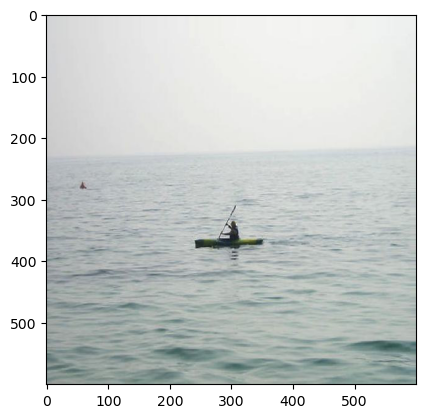

In [44]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from PIL import Image

# Load the EfficientNetB7 model and modify for feature extraction
efficientnet_model = EfficientNetB7(weights='imagenet')
efficientnet_model = Model(inputs=efficientnet_model.inputs, outputs=efficientnet_model.layers[-2].output)

# Path to the image
image_path = r"D:\minor2\augmented_images\19212715_20476497a3_0_8806.jpg"

# Load and preprocess the image
image = load_img(image_path, target_size=(600, 600))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
plt.imshow(Image.open(image_path))
image = preprocess_input(image)

# Extract features using the EfficientNetB7 model
feature = efficientnet_model.predict(image, verbose=0)

# Ensure max_length matches expected model input shape
max_length = 37  # Adjust this to match the training sequence length

# Predict caption
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        # Model prediction
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        
        # Convert predicted index to word
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

# Run prediction
caption = predict_caption(model, feature, tokenizer, max_length)
print("Generated Caption:", caption)


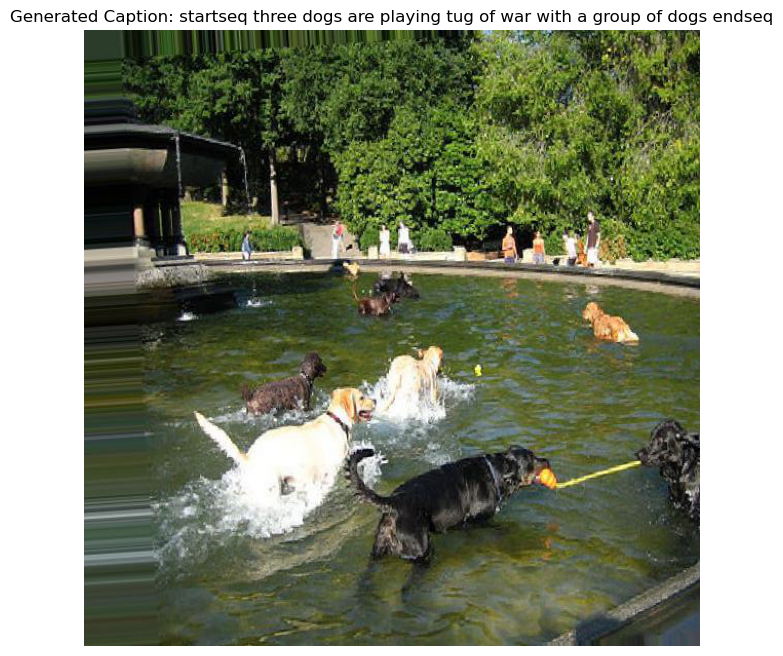

Step 1: startseq three
Step 2: startseq three dogs
Step 3: startseq three dogs are
Step 4: startseq three dogs are playing
Step 5: startseq three dogs are playing tug
Step 6: startseq three dogs are playing tug of
Step 7: startseq three dogs are playing tug of war
Step 8: startseq three dogs are playing tug of war with
Step 9: startseq three dogs are playing tug of war with a
Step 10: startseq three dogs are playing tug of war with a group
Step 11: startseq three dogs are playing tug of war with a group of
Step 12: startseq three dogs are playing tug of war with a group of dogs
Step 13: startseq three dogs are playing tug of war with a group of dogs endseq


In [53]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from PIL import Image
import matplotlib.pyplot as plt
import pickle

# Load pre-trained VGG16 model (without the top layers) to extract image features
def extract_image_features(image_path):
    # Load the EfficientNetB7 model
    efficientnet_model = EfficientNetB7(weights='imagenet')
    efficientnet_model = Model(inputs=efficientnet_model.inputs, outputs=efficientnet_model.layers[-2].output)
    image = load_img(image_path, target_size=(600, 600))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    
    features = efficientnet_model.predict(image, verbose=0)
    return features

# Helper function to convert index to word
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Function to generate a caption for an image
def generate_caption(model, tokenizer, image_features, max_length):
    in_text = 'startseq'
    captions = []  # To store the step-by-step generated words
    
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        yhat = model.predict([image_features, sequence], verbose=0)
        yhat = np.argmax(yhat)
        
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        captions.append(in_text)
        
        if word == 'endseq':
            break
    
    return captions

# Load the tokenizer (assuming it's saved as a pickle file)
with open('tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Load the trained captioning model
model = load_model(r"D:\minor2\efficientnetb7.keras")

# **Correct max_length**: Set it to 37 as expected by the model
max_length = 37

# Test the model on a new image
image_path = r"D:\minor2\augmented_images\41999070_838089137e_0_472.jpg"
image_features = extract_image_features(image_path)

# Generate a caption for the image
captions = generate_caption(model, tokenizer, image_features, max_length)
final_caption = captions[-1]

# Display the image
img = Image.open(image_path)
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.title("Generated Caption: " + final_caption)
plt.show()

# Display the step-by-step generation process (optional)
for i, step_caption in enumerate(captions):
    print(f"Step {i+1}: {step_caption}")
